## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import pickle
import gzip
from memory_profiler import memory_usage
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

tf.random.set_seed(5)

## Data Loading

In [2]:
def convert_x(x):
    '''helper function to convert numpy array to proper format'''
    return x / 255.0 # normalize, and ensure correct indicies for model,  x.transpose(0, 3, 1, 2)

def load_from_pickle_files(prefix, path):
    '''helper function to load pickle files and return the numpy arrays we need'''
    with gzip.open(os.path.join(path, prefix + '_x_train.gz'), 'rb') as i:
        x_train = pickle.load(i)
    with gzip.open(os.path.join(path, prefix + '_x_val.gz'), 'rb') as i:
        x_valid = pickle.load(i)    
    with gzip.open(os.path.join(path, prefix + '_x_test.gz'), 'rb') as i:
        x_test = pickle.load(i)  
    with gzip.open(os.path.join(path, prefix + '_y_train.gz'), 'rb') as i:
        y_train = pickle.load(i)  
    with gzip.open(os.path.join(path, prefix + '_y_val.gz'), 'rb') as i:
        y_valid = pickle.load(i) 
    with gzip.open(os.path.join(path, prefix + '_y_test.gz'), 'rb') as i:
        y_test = pickle.load(i) 
    
    x_train = convert_x(x_train)
    y_train = y_train.flatten()

    x_valid = convert_x(x_valid)
    y_valid = y_valid.flatten()

    x_test = convert_x(x_test)
    y_test = y_test.flatten()

    # convert to tensorflow tensors
    x_train = tf.convert_to_tensor(np.array(x_train, dtype=np.float32), dtype=tf.float32)
    y_train = tf.convert_to_tensor(np.array(y_train, dtype=np.float32), dtype=tf.float32)
    x_test = tf.convert_to_tensor(np.array(x_test, dtype=np.float32), dtype=tf.float32)
    y_test = tf.convert_to_tensor(np.array(y_test, dtype=np.float32), dtype=tf.float32)
    x_valid = tf.convert_to_tensor(np.array(x_valid, dtype=np.float32), dtype=tf.float32)
    y_valid = tf.convert_to_tensor(np.array(y_valid, dtype=np.float32), dtype=tf.float32)

    return x_train, x_valid, x_test, y_train, y_valid, y_test       

## Metric Helper Functions

In [3]:
def get_memory_usage_and_runtime(train_function, arguments):
    '''
    gets peak memory usage of the training function in MB and runtime in seconds
    
    @param train_function: the model's training loop
    @param arguments: tuple of arguments for the function
    @return runtime (s), peak_mem (MB), result (return of the function)
    NOTE - if the function has no return values or arguments, run it like this: 
    mem = memory_usage(proc=train_function)
    '''

    s = time.time()
    mem, result = memory_usage((train_function, arguments), retval=True)
    e = time.time()
    runtime = e-s
    peak_mem = max(mem)
    
    return runtime, peak_mem, result


def get_epsilon_momentents_gaussian_dp(num_train_data, noise_multiplier, num_epochs, batch_size):
    '''
    calculates epsilon (ε) of the differentially private model. The model is said to be ε-differentially private if the model cannot differentiate 
    between two datasets that differ by one point. 
    @param num_training_data (int): the number of training examples
    @param noise_multiplier (double): standard deviation of the gaussian noise added to the gradients 
    @param num_epochs (int): number of epochs the model ran for
    @param batch_size (int): batch size used
    @returns epsilon(int) : epsilon value
    NOTE - to disable warning messages add this: 
        from absl import logging as absl_logging
        absl_logging.set_verbosity(absl_logging.ERROR)
    '''
    delta = 1e-5 #typical value for delta 

    # compute the privacy budget
    epsilon, __ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
        n=num_train_data,
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=num_epochs,
        delta=delta,
    )
    return epsilon

def dump_metrics_to_json(filename, runtime, peak_mem, test_accuracy, epsilon=0, is_dp=False):
    '''
    dumps all the metrics from the model to a text file with the name filename
    @param filename (string): filename, must end with .txt
    @param runtime (float): runtime of training in seconds
    @param peak_mem (float): peak memory of training in MB
    @param epsilon (float): epsilon from gaussian DP
    @param is_dp (boolean): true if the model had differential privacy incorporated
    '''

    if is_dp:
        privacy_utility = epsilon/test_accuracy
        metrics = f"Runtime(s): {runtime}\nPeak Mem(MB): {peak_mem}\nTest Accuracy: {test_accuracy}\nEpsilon: {epsilon}\nUtility: {privacy_utility}"
    else:
        metrics = f"Runtime(s): {runtime}\nPeak Mem(MB): {peak_mem}\nTest Accuracy: {test_accuracy}"

    with open(filename, 'w') as f:
        f.write(metrics)

## Defining CNN

In [4]:
class CNN(tf.keras.Model):
    def __init__(self, inputshape):
        super().__init__()
        self.conv1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu', dtype='float32', padding = 'same', input_shape = inputshape)
        self.pool = layers.MaxPool2D(pool_size = 2)
        self.conv2 = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')
        self.fc1 = layers.Dense(units = 32, activation = 'relu')
        self.fc2 = layers.Dense(units = 10, activation = 'softmax')
        self.flat = layers.Flatten()
            
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## Regular SGD

In [5]:
def train_sgd(x_train, y_train, x_valid, y_valid, model, epoch_num, batch_size):
    train_accuracies = []
    valid_accuracies = []

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    val_dataset = val_dataset.batch(batch_size)

    for epoch in range(epoch_num):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fcn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            train_acc_metric.update_state(y_batch_train, logits)
        train_accuracy = float(train_acc_metric.result())
        train_accuracies.append(train_accuracy)
        train_acc_metric.reset_states()

        for step, (x_batch_valid, y_batch_valid) in enumerate(val_dataset):
            val_logits = model(x_batch_valid, training=False)
            valid_acc_metric.update_state(y_batch_valid, val_logits)
        valid_accuracy = float(valid_acc_metric.result())
        valid_accuracies.append(valid_accuracy)
        valid_acc_metric.reset_states()

        print("Epoch", epoch+1, "Training Accuracy: ", train_accuracy, ", Validation Accuracy: ",  valid_accuracy)
    return train_accuracies, valid_accuracies


## DP-SGD-JL

In [6]:
def RMS(A):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(A)))

In [7]:
def train_dp_sgd_jl(x_train, y_train, x_valid, y_valid, model, epoch_num, batch_size):
    train_accuracies = []
    valid_accuracies = []

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    val_dataset = val_dataset.batch(batch_size)

    # Need to use a test variable to initialize the trainable weights of the model
    test = tf.ones((1, 64, 64, 3))
    output = model(test)
    #print(len(model.trainable_weights))

    for epoch in range(epoch_num):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            #a = time.time()
            P = []  # store Pij
            M = []  # store per sample gradient norm estimates

            for j in range(r):
                #start = time.time()
                vj = [tf.random.normal(w.shape) for w in model.trainable_weights]
                with tf.autodiff.ForwardAccumulator(model.trainable_weights, vj) as acc:
                    logits = model(x_batch_train, training=True)
                    F = loss_fcn(y_batch_train, logits)
                jvp = acc.jvp(F)
                P.append(jvp)
                #print('Time to complete jvp for v_j:', time.time()-start)

            P = tf.stack(P)

            for i in range(len(x_batch_train)):
                M.append(RMS(tf.gather(P, i, axis=1)))

            M = tf.convert_to_tensor(M, dtype=tf.float32)   # {M_i}
            clipped_M = tf.clip_by_value(M, clip_value_min=-np.inf, clip_value_max=C)   # min{M_i, C}
            scale = tf.math.divide_no_nan(clipped_M, M)     # min{1, C/M_i}

            with tf.GradientTape(persistent=True) as tape:
                logits = model(x_batch_train, training=True)
                F = loss_fcn(y_batch_train, logits)
                average_loss = tf.tensordot(scale, F, 1)/len(scale)

            g = tape.gradient(average_loss, model.trainable_weights)
            coeff = sigma*C/len(x_batch_train)
            noise = [coeff*tf.random.normal(w.shape) for w in model.trainable_weights]
            g = g + noise
            optimizer.apply_gradients(zip(g, model.trainable_weights))
            train_acc_metric.update_state(y_batch_train, logits)

            #print('Time to complete batch:', time.time()-a)

        #print('calculated loss values')

        train_accuracy = float(train_acc_metric.result())
        train_accuracies.append(train_accuracy)
        train_acc_metric.reset_states()

        for step, (x_batch_valid, y_batch_valid) in enumerate(val_dataset):
            val_logits = model(x_batch_valid, training=False)
            valid_acc_metric.update_state(y_batch_valid, val_logits)
        valid_accuracy = float(valid_acc_metric.result())
        valid_accuracies.append(valid_accuracy)
        valid_acc_metric.reset_states()

        print("Epoch", epoch+1, ", Training Accuracy: ", train_accuracy, "Validation Accuracy: ",  valid_accuracy) # "Training Accuracy: ", train_accuracy, 
    return train_accuracies, valid_accuracies #train_accuracies, 

## Training

#### Chest Data

In [8]:
path = os.path.join(os.path.dirname(os.getcwd()), 'chest-data')
x_train, x_valid, x_test, y_train, y_valid, y_test = load_from_pickle_files('chest', path)

In [9]:
# hyperparameters
epochs = 100
batch = 100
lr = 0.01

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# training
sgd_model_c = CNN(x_test[0].shape)
rt_sgd_c, pm_sgd_c, (train_accuracies_sgd_c, valid_accuracies_sgd_c) = get_memory_usage_and_runtime(train_sgd, (x_train, y_train, x_valid, y_valid, sgd_model_c, epochs, batch))
output = sgd_model_c(tf.Variable(x_test))
acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
test_accuracy_sgd_c = float(acc.result())

Epoch 1 Training Accuracy:  0.598707377910614 , Validation Accuracy:  0.7047781348228455
Epoch 2 Training Accuracy:  0.6833137273788452 , Validation Accuracy:  0.7269624471664429
Epoch 3 Training Accuracy:  0.7463278770446777 , Validation Accuracy:  0.8634812235832214
Epoch 4 Training Accuracy:  0.7679200768470764 , Validation Accuracy:  0.8771331310272217
Epoch 5 Training Accuracy:  0.8018507361412048 , Validation Accuracy:  0.8907849788665771
Epoch 6 Training Accuracy:  0.8497356176376343 , Validation Accuracy:  0.7610921263694763
Epoch 7 Training Accuracy:  0.8594300746917725 , Validation Accuracy:  0.8242321014404297
Epoch 8 Training Accuracy:  0.8866040110588074 , Validation Accuracy:  0.9197952151298523
Epoch 9 Training Accuracy:  0.8943889737129211 , Validation Accuracy:  0.9232081770896912
Epoch 10 Training Accuracy:  0.9118683934211731 , Validation Accuracy:  0.9197952151298523
Epoch 11 Training Accuracy:  0.9153936505317688 , Validation Accuracy:  0.9283276200294495
Epoch 12 

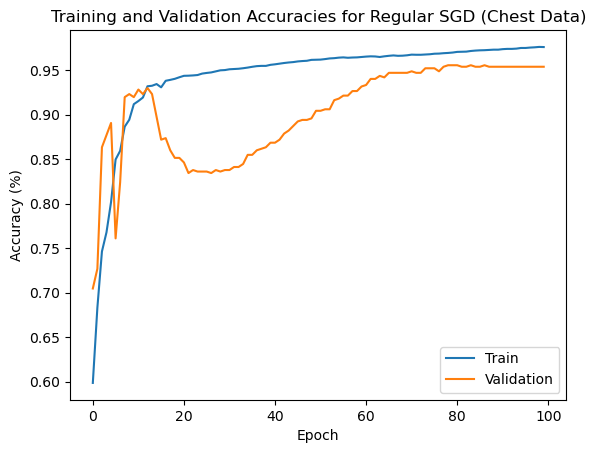

In [10]:
plt.title("Training and Validation Accuracies for Regular SGD (Chest Data)")
plt.plot(train_accuracies_sgd_c, label="Train")
plt.plot(valid_accuracies_sgd_c, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [11]:
# hyperparameters
epochs = 100
batch = 100
lr = 0.01
sigma = 4
C = 80. 
r = 5 # number of JL projections

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# training
dp_sgd_jl_model_c = CNN(x_test[0].shape)
rt_dp_c, pm_dp_c, (train_accuracies_dp_c, valid_accuracies_dp_c) = get_memory_usage_and_runtime(train_dp_sgd_jl, (x_train, y_train, x_valid, y_valid, dp_sgd_jl_model_c, epochs, batch))
epsilon_c = get_epsilon_momentents_gaussian_dp(len(x_train), sigma, epochs, batch)
output = dp_sgd_jl_model_c(tf.Variable(x_test))

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
test_accuracy_dp_c = float(acc.result())

Epoch 1 , Training Accuracy:  0.6106051802635193 Validation Accuracy:  0.6996586918830872
Epoch 2 , Training Accuracy:  0.7081375122070312 Validation Accuracy:  0.7866894006729126
Epoch 3 , Training Accuracy:  0.7510281801223755 Validation Accuracy:  0.8139931559562683
Epoch 4 , Training Accuracy:  0.8015570044517517 Validation Accuracy:  0.650170624256134
Epoch 5 , Training Accuracy:  0.8409224152565002 Validation Accuracy:  0.7866894006729126
Epoch 6 , Training Accuracy:  0.8720622658729553 Validation Accuracy:  0.7935153841972351
Epoch 7 , Training Accuracy:  0.875 Validation Accuracy:  0.9078498482704163
Epoch 8 , Training Accuracy:  0.891010582447052 Validation Accuracy:  0.9249146580696106
Epoch 9 , Training Accuracy:  0.9046709537506104 Validation Accuracy:  0.9215016961097717
Epoch 10 , Training Accuracy:  0.913337230682373 Validation Accuracy:  0.9215016961097717
Epoch 11 , Training Accuracy:  0.9192126989364624 Validation Accuracy:  0.92662113904953
Epoch 12 , Training Accura

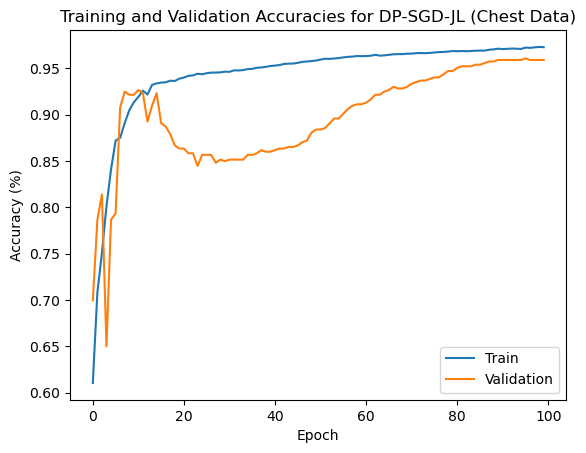

In [12]:
plt.title("Training and Validation Accuracies for DP-SGD-JL (Chest Data)")
plt.plot(train_accuracies_dp_c, label="Train")
plt.plot(valid_accuracies_dp_c, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

#### Knee Data

In [13]:
path = os.path.join(os.path.dirname(os.getcwd()), 'knee-data')
x_train, x_valid, x_test, y_train, y_valid, y_test = load_from_pickle_files('knee', path)

In [14]:
# hyperparameters
epochs = 100
batch = 100
lr = 0.01

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# training
sgd_model_k = CNN(x_test[0].shape)
rt_sgd_k, pm_sgd_k, (train_accuracies_sgd_k, valid_accuracies_sgd_k) = get_memory_usage_and_runtime(train_sgd, (x_train, y_train, x_valid, y_valid, sgd_model_k, epochs, batch))
output = sgd_model_k(tf.Variable(x_test))
acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
test_accuracy_sgd_k = float(acc.result())

Epoch 1 Training Accuracy:  0.3008117377758026 , Validation Accuracy:  0.2711864411830902
Epoch 2 Training Accuracy:  0.33451876044273376 , Validation Accuracy:  0.27966102957725525
Epoch 3 Training Accuracy:  0.3459605574607849 , Validation Accuracy:  0.2978208363056183
Epoch 4 Training Accuracy:  0.35616543889045715 , Validation Accuracy:  0.30145278573036194
Epoch 5 Training Accuracy:  0.36343255639076233 , Validation Accuracy:  0.30145278573036194
Epoch 6 Training Accuracy:  0.3690761625766754 , Validation Accuracy:  0.309927374124527
Epoch 7 Training Accuracy:  0.37170466780662537 , Validation Accuracy:  0.29903146624565125
Epoch 8 Training Accuracy:  0.37340548634529114 , Validation Accuracy:  0.309927374124527
Epoch 9 Training Accuracy:  0.3788171708583832 , Validation Accuracy:  0.2978208363056183
Epoch 10 Training Accuracy:  0.38051795959472656 , Validation Accuracy:  0.2881355881690979
Epoch 11 Training Accuracy:  0.38214147090911865 , Validation Accuracy:  0.2917675673961639

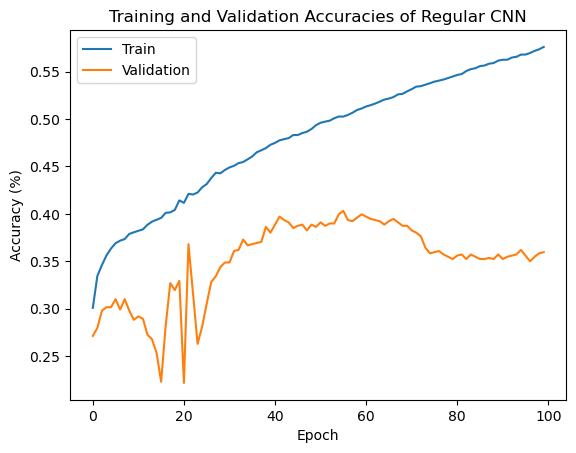

In [15]:
plt.title("Training and Validation Accuracies of Regular CNN")
plt.plot(train_accuracies_sgd_k, label="Train")
plt.plot(valid_accuracies_sgd_k, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [16]:
# hyperparameters
epochs = 100
batch = 100
lr = 0.01
sigma = 4
C = 80. 
r = 5 # number of JL projections

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# training
dp_sgd_jl_model_k = CNN(x_test[0].shape)
rt_dp_k, pm_dp_k, (train_accuracies_dp_k, valid_accuracies_dp_k) = get_memory_usage_and_runtime(train_dp_sgd_jl, (x_train, y_train, x_valid, y_valid, dp_sgd_jl_model_k, epochs, batch))
epsilon_k = get_epsilon_momentents_gaussian_dp(len(x_train), sigma, epochs, batch)
output = dp_sgd_jl_model_k(tf.Variable(x_test))

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
test_accuracy_dp_k = float(acc.result())

Epoch 1 , Training Accuracy:  0.29462698101997375 Validation Accuracy:  0.15375302731990814
Epoch 2 , Training Accuracy:  0.3300347924232483 Validation Accuracy:  0.2808716595172882
Epoch 3 , Training Accuracy:  0.344878226518631 Validation Accuracy:  0.29418885707855225
Epoch 4 , Training Accuracy:  0.3535369038581848 Validation Accuracy:  0.2832929790019989
Epoch 5 , Training Accuracy:  0.3620409667491913 Validation Accuracy:  0.2978208363056183
Epoch 6 , Training Accuracy:  0.3660610616207123 Validation Accuracy:  0.309927374124527
Epoch 7 , Training Accuracy:  0.37015849351882935 Validation Accuracy:  0.31355932354927063
Epoch 8 , Training Accuracy:  0.3727869987487793 Validation Accuracy:  0.309927374124527
Epoch 9 , Training Accuracy:  0.375570148229599 Validation Accuracy:  0.309927374124527
Epoch 10 , Training Accuracy:  0.3795902729034424 Validation Accuracy:  0.3075060546398163
Epoch 11 , Training Accuracy:  0.38129106163978577 Validation Accuracy:  0.2881355881690979
Epoch 1

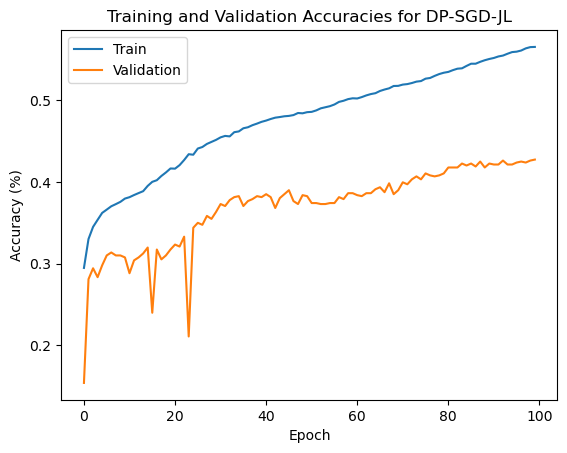

In [17]:
plt.title("Training and Validation Accuracies for DP-SGD-JL")
plt.plot(train_accuracies_dp_k, label="Train")
plt.plot(valid_accuracies_dp_k, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [19]:
dump_metrics_to_json("tf_keras_SGD_chest.txt", rt_sgd_c, pm_sgd_c, test_accuracy_sgd_c)
dump_metrics_to_json("tf_keras_DP_SGD_JL_chest.txt", rt_dp_c, pm_dp_c, test_accuracy_dp_c, epsilon_c, is_dp=True)
dump_metrics_to_json("tf_keras_SGD_knee.txt", rt_sgd_k, pm_sgd_k, test_accuracy_sgd_k)
dump_metrics_to_json("tf_keras_DP_SGD_JL_knee.txt", rt_dp_k, pm_dp_k, test_accuracy_dp_k, epsilon_k, is_dp=True)